In [29]:
import sys
import h5py
import matplotlib.pyplot as plt
from matplotlib.image import NonUniformImage
import numpy as np
from matplotlib.colors import Normalize, LogNorm
from matplotlib.cm import ScalarMappable
from matplotlib.colors import LinearSegmentedColormap
from scipy.constants import c, pi, e, m_e, epsilon_0

In [30]:
density = 5e14
density*=1e6 #/m3
wp = np.sqrt(density*e**2/epsilon_0/m_e)
kp=wp/c
lamdap = 2*pi/kp
E_WB = c*m_e*wp/e # wavebreaking field
E_WB/=1e9 #GeV
print(12/kp)
print(.01/kp)
print(0.0002851841705201041*kp)
print(lamdap*kp/2)

0.0028518417052010407
2.3765347543342008e-06
1.2000000000000002
3.141592653589793


In [42]:
# Set global font size
# plt.rcParams.update({'font.size': 16})  # Set desired font size

def create_custom_cmap(color):
    # Create a color map that goes from transparent to the specified color
    # The gradient is defined as: (0, 0, 0, 0) -> (color with full opacity)
    cmap = LinearSegmentedColormap.from_list("custom_cmap", [(1, 1, 1, 0), color], N=256)
    return cmap


filenum = 1 #int(sys.argv[2])
#filedir = '/home/novac/Desktop/my_projects/PaperFiles/h5py-Fig6/n14' #sys.argv[1]
filedir = '/home/novac/Desktop/my_projects/qv3d-automation/simulation-densScan/density-5e14'
filedir = '/home/novac/Desktop/my_projects/qv3d-automation/simulation'
filename = f"{filedir}/h5files/v2d_mframe_{str(filenum).zfill(5)}.h5"

# Attempt to open the HDF5 file
try:
    file = h5py.File(filename, 'r')
    print(f"file = {filename}")
except IOError:
    sys.stderr.write(f"File does not exist:\n  {filename}\n")
    sys.exit(-1)

print(f"Phase = {file['phase'][0]}")

file = /home/novac/Desktop/my_projects/qv3d-automation/simulation/h5files/v2d_mframe_00001.h5
Phase = 1.000000013351432e-10


In [43]:
file["n0"].shape

(100, 70)

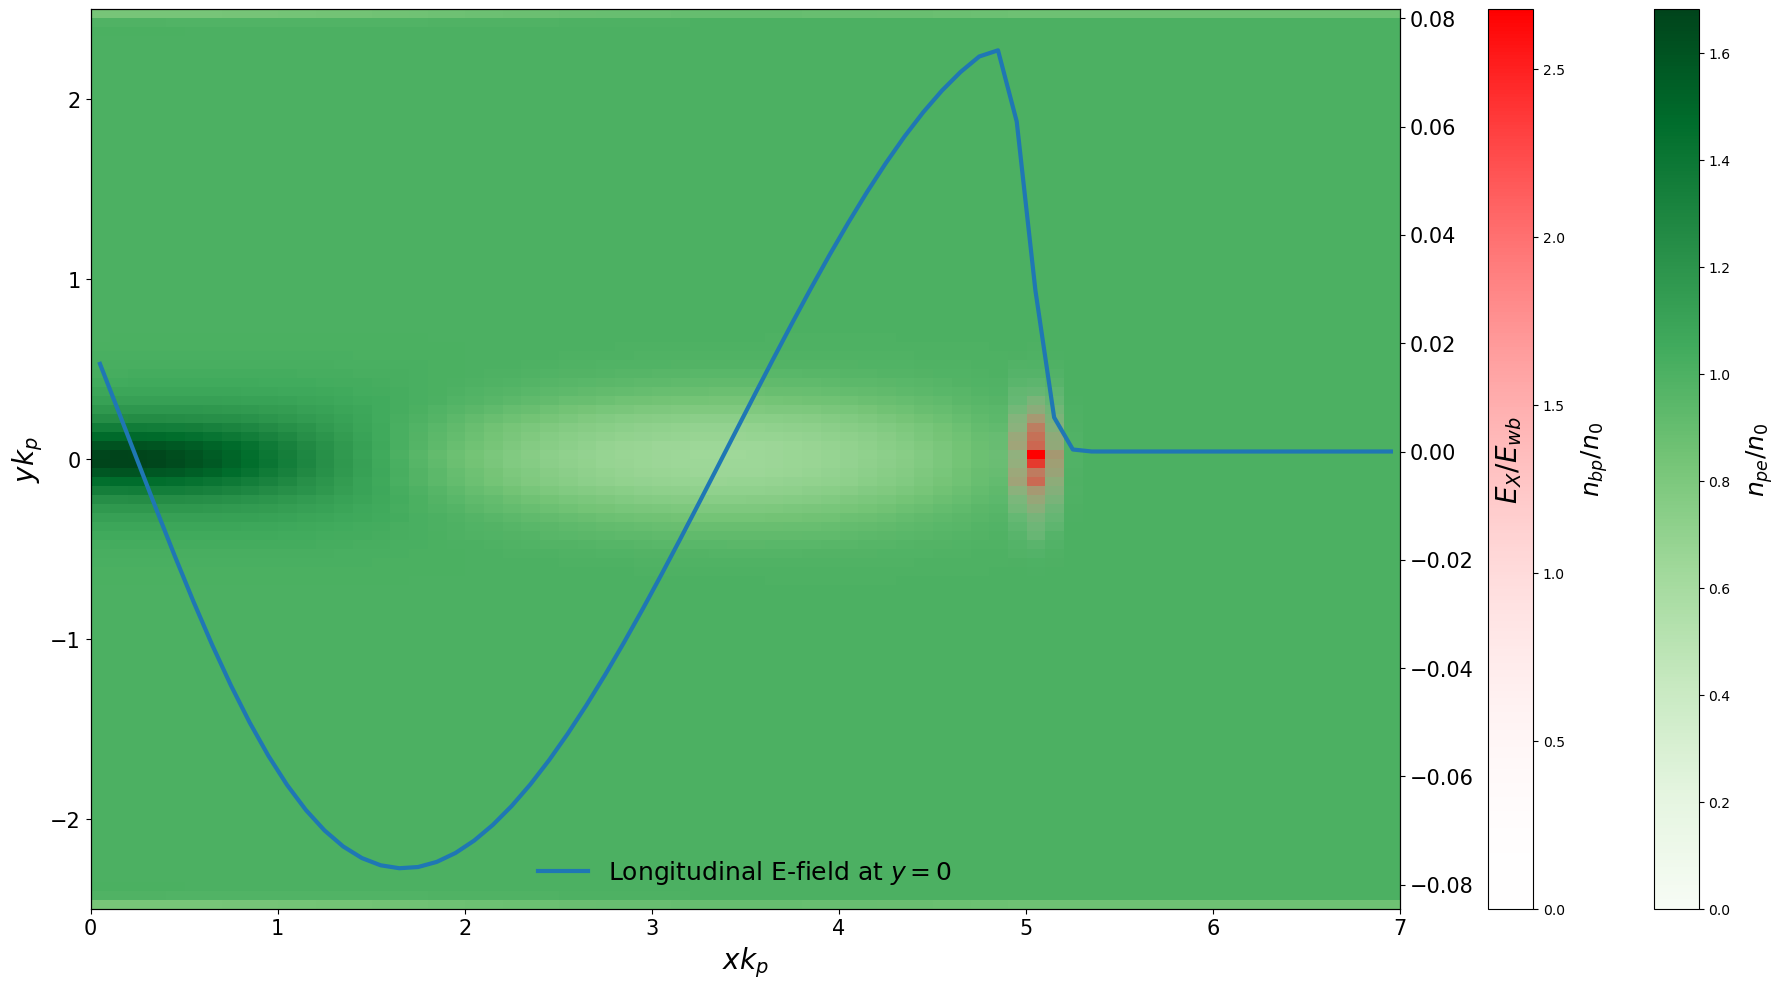

In [44]:
# Read grid coordinates
X = file["X"][:]
Y = file["Y"][:]


# Calculate plot limits
Xmin = X[0] + 0.5 * (X[0] - X[1])
Xmax = X[-1] + 0.5 * (X[-1] - X[-2])
Ymin = Y[0] + 0.5 * (Y[0] - Y[1])
Ymax = Y[-1] + 0.5 * (Y[-1] - Y[-2])


#custom cmap for proton bunch
# Example color
color = 'red'  # or any other color you want
# Step 2: Create the custom colormap
proton_cmap = create_custom_cmap(color)

# Specify fields to plot
fields = ["n0", "n1", "n2"]  
fields = ["n0", "n1"]  
cmaps = ["Greens", proton_cmap, "BuPu"]  # Set colormaps for densities


# Create figure for plotting
fig, ax = plt.subplots(figsize=(18, 10))  # Create a single subplot

# Set the figure title
fig.canvas.manager.set_window_title(f'{filedir} {filenum}')

# Loop over the fields to create overlay plots
for i, field in enumerate(fields):
    #data = np.transpose(file[field][:]) # Remove if the plot comes out sideways
    data = (file[field][:]) # Remove if the plot comes out sideways
    
    # Create a custom colormap
    cmap = plt.get_cmap(cmaps[i])
    
    # Normalize the data
    norm = Normalize(vmin=0, vmax=np.max(data))
    
    # Create a mask for low values (adjust threshold as necessary)
    low_value_mask = data < 0.005 * np.max(data)  # Mask values below 10% of the max
    
    # Create an RGBA array from the colormap
    rgba_data = cmap(norm(data))  # Apply the colormap
    rgba_data[low_value_mask, 3] = 0  # Set alpha channel to 0 for low values (transparent)
    
    # Plot the data using the RGBA array
    im = ax.imshow(rgba_data, extent=(Xmin, Xmax, Ymin, Ymax), aspect='auto', interpolation='nearest')

    # Add a color bar for the current field with its respective colormap
    # Move colour bars a little to the right to space them out more
    if i == 2:
        cbar = plt.colorbar(ScalarMappable(norm=norm, cmap=cmaps[i]), ax=ax, fraction=0.046, pad=0.14)
    else:
        cbar = plt.colorbar(ScalarMappable(norm=norm, cmap=cmaps[i]), ax=ax, fraction=0.046, pad=0.06)

    
    titles = [r"$n_{pe}/n_{0}$", r"$n_{bp}/n_{0}$", r"$n_{be}/n_{0}$"]
    cbar.set_label(titles[i], fontsize=18, labelpad=10)

     
if field[0]=="n":
    #data = np.transpose(file[field][:]) # Remove if the plot comes out sideways
    # Plotting curves onto density map
    E_y_index = np.argmin(np.abs(Y))  # Finds the index of the closest value to y = 0
    Fy_y0_index = np.argmin(np.abs(Y-0.5951))  # Finds the index of the closest y = sigr = 0.0406 value 
    Ex_field = np.transpose(file["ex"])[:, E_y_index]
    Trans_field = np.transpose(file["ForceY"])[:, Fy_y0_index]
    X_array=X[:]
    ax2 = ax.twinx() # Field on right hand axis
    ax2.plot(X_array, Ex_field*E_WB, lw=3, color='tab:blue', label=r'Longitudinal E-field at $y=0$')
    #ax2.plot(X_array, 2*Trans_field*E_WB, lw=3, color='tab:red', label=r'Transverse Wakefield at $y = \sigma_{r}$')
    #ax2.set_ylabel(r"$E_{X}/E_{wb}, 10*W_{Y}/E_{wb}$", fontsize=20, labelpad=15)
    ax2.set_ylabel(r"$E_{X}/E_{wb}$", fontsize=20, labelpad=15)
    #ax2.set_ylim([-0.22, 0.22]) # Centres y-axis on 0 (hard coded)
    ax2.tick_params(axis='both', labelsize=15)
    ax2.legend(loc='lower center', frameon=False, fontsize=18)
# Set limits for the axes
ax.set_xlim(Xmin, Xmax)
ax.set_ylim(Ymin, Ymax)
ax.tick_params(axis='both', labelsize=15)


# Set a title for the overall plot
#ax.set_title(f"QV3D simulation of AWAKE Run 2 at " + str((int(third_arg)-1)*2) + "m", fontsize=22)
ax.set_xlabel(r"$x k_{p}$", fontsize=20)
ax.set_ylabel(r"$y k_{p}$", fontsize=20)

plt.tight_layout()  # Adjust layout to prevent overlap

# Save the plot as a PNG file with a fixed name followed by the 3rd argument value
#output_filename = rf'C:\Users\jaspe\OneDrive - The University of Manchester\Documents\Physics\MPhys_Project\mphys_docs\Python_scripts\plots\overlay_field_plot_high_res_{third_arg}.png'
plt.savefig('density_plot.png', format='png', dpi=300)  # Save at 300 DPI for high quality
plt.savefig('density_plot.png', format='png', dpi=300)  # Save at 300 DPI for high quality


# Show the plot
plt.show()

# Close the HDF5 file
file.close()

In [41]:
E_y_index

49